In [1]:
# Latent grid sampling and structural property mapping

# This notebook samples the latent space of a trained VAE in a 2D grid
# (select two latent dimensions, fix others), decodes structures, computes
# scalar properties (loop frequency, average loop size, radius of gyration),
# and plots multi-panel heatmaps (one per property) over the latent grid.

import os
from pathlib import Path
from typing import Tuple, Dict, Any

import numpy as np
import torch

# Absolute paths (edit as needed)
PROJECT_ROOT = Path('/scratch/amk19/ChromVAE/ChromVAE')
MODEL_PATH = PROJECT_ROOT / 'outputs' / 'trained_vae_model_RMSD.pt'
PDB_DATA_PATH = PROJECT_ROOT / 'Data' / 'chromosome21_aligned.pdb'
OUTPUT_DIR = PROJECT_ROOT / 'outputs' / 'Generated_Samples'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Model hyperparameters (must match the trained model)
HIDDEN_DIM = 4096
LATENT_DIM = 256  # trained in Train/main_RMSD.py

# Import project modules
import sys
sys.path.append(str(PROJECT_ROOT))
from VAE.Simple_VAE import LGL_VAE
from DataLoader.Chromosome21PDBDataset import Chromosome21PDBDataset
from Utils.Utils import Utils

# Device
utils = Utils()
device = utils.device
print(f'Device: {device}')

# Infer input dimension from dataset for the decoder output shape
print('Loading dataset metadata to infer input dimension...')
dataset = Chromosome21PDBDataset(
    pdb_path=str(PDB_DATA_PATH),
    record_types=("ATOM",),
    center=False,
    scale=1.0,
)
input_dim = dataset.vector_length
num_atoms = dataset.atoms_per_model
print(f'Input dim: {input_dim}, Atoms per model: {num_atoms}')

# Build model and load checkpoint
model = LGL_VAE(hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM, input_dim=input_dim)
model = model.to(device)
ckpt = torch.load(str(MODEL_PATH), map_location=device)
if any(k.startswith('module.') for k in ckpt.keys()):
    ckpt = { (k[7:] if k.startswith('module.') else k): v for k, v in ckpt.items() }
model.load_state_dict(ckpt)
model.eval()
print('Loaded trained VAE.')

@torch.no_grad()
def decode_from_latents(z: torch.Tensor) -> torch.Tensor:
    """Decode latent batch z -> flattened coordinates [B, 3*num_atoms]."""
    model.eval()
    return model.decoder(z.to(device))


Device: cpu
Loading dataset metadata to infer input dimension...
Input dim: 1953, Atoms per model: 651
Loaded trained VAE.


In [9]:
# Latent grid sampling (select dims, range, resolution)

import math

# Configuration for grid sampling
GRID_SIZE = 100              # number of steps per axis (NxN); adjust as needed
LATENT_DIM_X = 0             # first latent dimension to scan
LATENT_DIM_Y = 1             # second latent dimension to scan
GRID_RANGE = (-50.0, 50.0)     # range on each axis
BATCH_SIZE = 256             # decode batch size
BASE_LATENT_VALUE = 0.0      # value for non-scanned latent dims

print(f'Grid: {GRID_SIZE}x{GRID_SIZE} over dims ({LATENT_DIM_X}, {LATENT_DIM_Y}) in range {GRID_RANGE}')

# Build grid coordinates
x_vals = np.linspace(GRID_RANGE[0], GRID_RANGE[1], GRID_SIZE, dtype=np.float32)
y_vals = np.linspace(GRID_RANGE[0], GRID_RANGE[1], GRID_SIZE, dtype=np.float32)
X, Y = np.meshgrid(x_vals, y_vals, indexing='xy')  # shape [GRID_SIZE, GRID_SIZE]

# Prepare latent matrix [N, LATENT_DIM]
N = GRID_SIZE * GRID_SIZE
z = torch.full((N, LATENT_DIM), float(BASE_LATENT_VALUE), dtype=torch.float32, device=device)

# Fill the two selected dims with the grid
z[:, LATENT_DIM_X] = torch.from_numpy(X.reshape(-1)).to(device)
z[:, LATENT_DIM_Y] = torch.from_numpy(Y.reshape(-1)).to(device)

# Decode in batches
decoded_list = []
with torch.no_grad():
    for start in range(0, N, BATCH_SIZE):
        end = min(N, start + BATCH_SIZE)
        decoded_batch = decode_from_latents(z[start:end])  # [B, 3*num_atoms]
        decoded_list.append(decoded_batch.cpu())

decoded = torch.cat(decoded_list, dim=0)  # [N, 3*num_atoms]
coords = decoded.view(N, num_atoms, 3).numpy()  # [N, K, 3]
print(f'Decoded coords shape: {coords.shape}')

# Keep a copy of the grid for plotting
grid_x = X.copy()
grid_y = Y.copy()


Grid: 100x100 over dims (0, 1) in range (-50.0, 50.0)
Decoded coords shape: (10000, 651, 3)


In [ ]:
# Property computation: radius of gyration (Rg) only

def radius_of_gyration(xyz: np.ndarray) -> float:
    c = xyz.mean(axis=0, keepdims=True)
    dif = xyz - c
    return float(np.sqrt(np.mean(np.sum(dif * dif, axis=1))))

# Compute Rg for all grid coordinates
N = coords.shape[0]
rg = np.zeros((N,), dtype=np.float64)
for idx in range(N):
    xyz = coords[idx]  # [K, 3]
    rg[idx] = radius_of_gyration(xyz)

# Reshape to grid [GRID_SIZE, GRID_SIZE]
rg_grid = rg.reshape(GRID_SIZE, GRID_SIZE)
print('Computed: radius_of_gyration')


Computed properties: ['loop_frequency', 'avg_loop_size', 'radius_of_gyration']


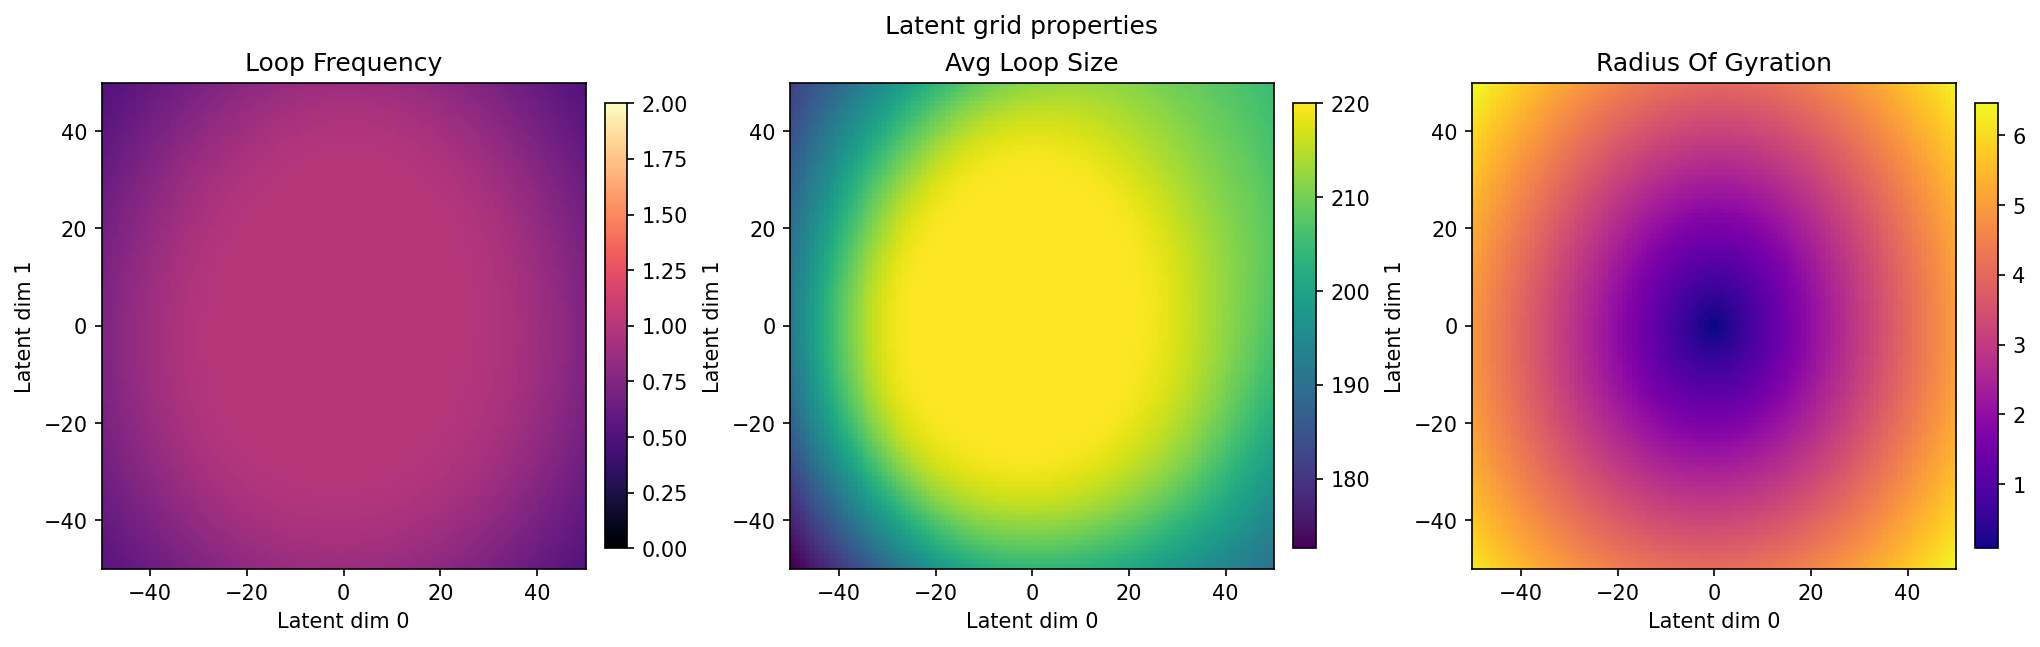

In [11]:
# Plotting multi-panel figure

import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams['figure.dpi'] = 150

# Choose properties to plot and their colormaps
plot_specs = [
    ('loop_frequency', 'magma'),
    ('avg_loop_size', 'viridis'),
    ('radius_of_gyration', 'plasma'),
]

# Optional vmin/vmax per property (set to None to auto-scale)
# Example: set loop_frequency to [0, 1]
vmin_vmax = {
    'loop_frequency': (0.0, 2.0),
    'avg_loop_size': (None, None),
    'radius_of_gyration': (None, None),
}

num_panels = len(plot_specs)
fig, axes = plt.subplots(1, num_panels, figsize=(4.5 * num_panels, 4.2), constrained_layout=True)
if num_panels == 1:
    axes = [axes]

for ax, (key, cmap) in zip(axes, plot_specs):
    mat = props_grid[key]
    vmin, vmax = vmin_vmax.get(key, (None, None))
    im = ax.imshow(
        mat,
        origin='lower',
        cmap=cmap,
        extent=(GRID_RANGE[0], GRID_RANGE[1], GRID_RANGE[0], GRID_RANGE[1]),
        aspect='auto',
        interpolation='nearest',
        vmin=vmin,
        vmax=vmax,
    )
    ax.set_title(key.replace('_', ' ').title())
    ax.set_xlabel(f'Latent dim {LATENT_DIM_X}')
    ax.set_ylabel(f'Latent dim {LATENT_DIM_Y}')
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle('Latent grid properties')
plt.show()


In [21]:
# Save graded properties and figure

# Save arrays
npz_path = OUTPUT_DIR / f'latent_grid_props_dim{LATENT_DIM_X}_{LATENT_DIM_Y}_N{GRID_SIZE}.npz'
np.savez_compressed(
    npz_path,
    grid_x=grid_x,
    grid_y=grid_y,
    loop_frequency=props_grid['loop_frequency'],
    avg_loop_size=props_grid['avg_loop_size'],
    radius_of_gyration=props_grid['radius_of_gyration'],
    config=dict(
        grid_size=GRID_SIZE,
        grid_range=GRID_RANGE,
        dims=(LATENT_DIM_X, LATENT_DIM_Y),
        contact_threshold=CONTACT_THRESHOLD,
        min_loop_sep=MIN_LOOP_SEP,
    ),
)
print(f'Saved arrays to {npz_path}')

# Save figure (rerun plotting cell first if you changed anything)
fig_path = OUTPUT_DIR / f'latent_grid_props_dim{LATENT_DIM_X}_{LATENT_DIM_Y}_N{GRID_SIZE}.png'
try:
    fig  # type: ignore[name-defined]
    fig.savefig(fig_path, dpi=200)
    print(f'Saved figure to {fig_path}')
except NameError:
    print('Figure handle not found. Re-run the plotting cell before saving the figure.')


Saved arrays to /scratch/amk19/ChromVAE/ChromVAE/outputs/Generated_Samples/latent_grid_props_dim0_1_N100.npz
Saved figure to /scratch/amk19/ChromVAE/ChromVAE/outputs/Generated_Samples/latent_grid_props_dim0_1_N100.png


In [22]:
# UMAP embedding of latent means (mu) to 2D

from torch.utils.data import DataLoader

# UMAP parameters
UMAP_N_NEIGHBORS = 50
UMAP_MIN_DIST = 0.1
UMAP_RANDOM_STATE = 0

# Build a dataloader to encode the dataset
ENCODE_BATCH_SIZE = 256
loader = DataLoader(
    dataset,
    batch_size=ENCODE_BATCH_SIZE,
    shuffle=False,
    collate_fn=Chromosome21PDBDataset.collate_batch,
)

# Collect latent means mu for all samples
all_mu = []
model.eval()
with torch.no_grad():
    for batch in loader:
        batch = batch.to(device)
        _, mu, _ = model(batch)
        all_mu.append(mu.cpu())
all_mu = torch.cat(all_mu, dim=0).numpy()  # [M, LATENT_DIM]
print(f'Encoded {all_mu.shape[0]} samples to latent means with dim {all_mu.shape[1]}')

# Fit UMAP to 2D
try:
    from umap import UMAP  # type: ignore
except Exception:
    from umap.umap_ import UMAP  # type: ignore

umap_model = UMAP(
    n_neighbors=UMAP_N_NEIGHBORS,
    min_dist=UMAP_MIN_DIST,
    n_components=2,
    metric='euclidean',
    random_state=UMAP_RANDOM_STATE,
)
U = umap_model.fit_transform(all_mu)  # [M, 2]
print('UMAP 2D embedding shape:', U.shape)


Encoded 7591 samples to latent means with dim 256


/scratch/amk19/ChromVAE/.venv/lib64/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


KeyboardInterrupt: 

In [23]:
# Compute properties on decoder reconstructions for the dataset (aligned with UMAP points)

recon_props = {
    'loop_frequency': np.zeros((len(dataset),), dtype=np.float64),
    'avg_loop_size': np.zeros((len(dataset),), dtype=np.float64),
    'radius_of_gyration': np.zeros((len(dataset),), dtype=np.float64),
}

idx_offset = 0
model.eval()
with torch.no_grad():
    for batch in loader:
        B = batch.shape[0]
        batch = batch.to(device)
        # Use latent means (deterministic) for reconstructions
        _, mu, _ = model(batch)
        decoded_batch = model.decoder(mu)
        coords_batch = decoded_batch.view(B, num_atoms, 3).cpu().numpy()
        for i in range(B):
            xyz = coords_batch[i]
            dist = pairwise_distances(xyz)
            cm = contact_map_from_dist(dist, CONTACT_THRESHOLD)
            recon_props['loop_frequency'][idx_offset + i] = loop_frequency(cm, min_sep=MIN_LOOP_SEP)
            recon_props['avg_loop_size'][idx_offset + i] = average_loop_size(cm, min_sep=MIN_LOOP_SEP)
            recon_props['radius_of_gyration'][idx_offset + i] = radius_of_gyration(xyz)
        idx_offset += B

print('Computed reconstruction properties for dataset.')


KeyboardInterrupt: 

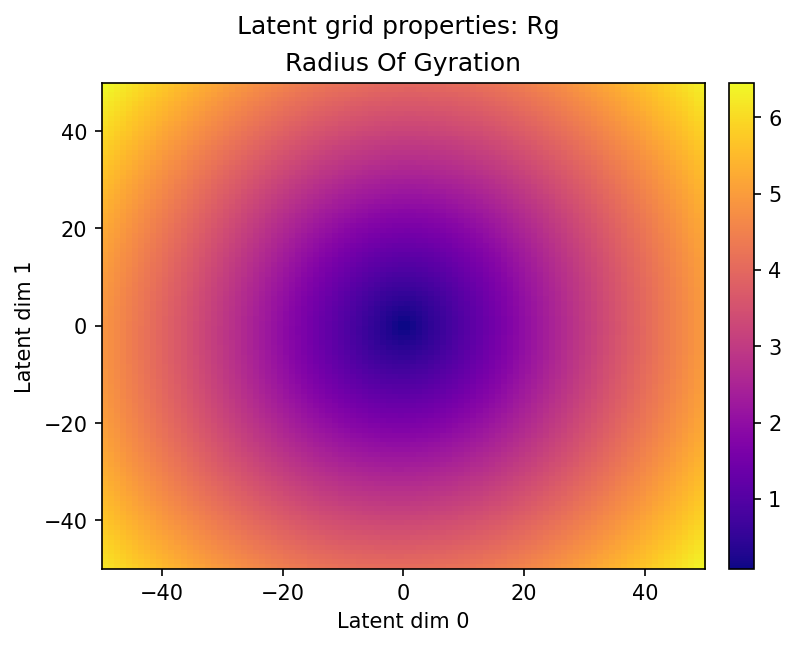

In [24]:
# Plot Rg heatmap (latent grid)

import matplotlib.pyplot as plt

# vmin/vmax for Rg (set to None to auto-scale)
RG_VMIN = None
RG_VMAX = None

# Fallback: compute rg_grid if not defined (e.g., if previous cell not run)
try:
    _ = rg_grid  # type: ignore[name-defined]
except NameError:
    N = coords.shape[0]
    rg = np.zeros((N,), dtype=np.float64)
    for idx in range(N):
        rg[idx] = radius_of_gyration(coords[idx])
    rg_grid = rg.reshape(GRID_SIZE, GRID_SIZE)

fig, ax = plt.subplots(1, 1, figsize=(5.2, 4.2), constrained_layout=True)
im = ax.imshow(
    rg_grid,
    origin='lower',
    cmap='plasma',
    extent=(GRID_RANGE[0], GRID_RANGE[1], GRID_RANGE[0], GRID_RANGE[1]),
    aspect='auto',
    interpolation='nearest',
    vmin=RG_VMIN,
    vmax=RG_VMAX,
)
ax.set_title('Radius Of Gyration')
ax.set_xlabel(f'Latent dim {LATENT_DIM_X}')
ax.set_ylabel(f'Latent dim {LATENT_DIM_Y}')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.suptitle('Latent grid properties: Rg')
plt.show()


In [25]:
# Save Rg grid and figure

npz_path = OUTPUT_DIR / f'latent_grid_Rg_dim{LATENT_DIM_X}_{LATENT_DIM_Y}_N{GRID_SIZE}.npz'
np.savez_compressed(
    npz_path,
    grid_x=grid_x,
    grid_y=grid_y,
    radius_of_gyration=rg_grid,
    config=dict(
        grid_size=GRID_SIZE,
        grid_range=GRID_RANGE,
        dims=(LATENT_DIM_X, LATENT_DIM_Y),
    ),
)
print(f'Saved arrays to {npz_path}')

fig_path = OUTPUT_DIR / f'latent_grid_Rg_dim{LATENT_DIM_X}_{LATENT_DIM_Y}_N{GRID_SIZE}.png'
try:
    fig  # type: ignore[name-defined]
    fig.savefig(fig_path, dpi=200)
    print(f'Saved figure to {fig_path}')
except NameError:
    print('Figure handle not found. Re-run the Rg plotting cell before saving the figure.')


Saved arrays to /scratch/amk19/ChromVAE/ChromVAE/outputs/Generated_Samples/latent_grid_Rg_dim0_1_N100.npz
Saved figure to /scratch/amk19/ChromVAE/ChromVAE/outputs/Generated_Samples/latent_grid_Rg_dim0_1_N100.png


In [26]:
# UMAP: compute Rg for dataset reconstructions only

from torch.utils.data import DataLoader

ENCODE_BATCH_SIZE = 256
loader = DataLoader(
    dataset,
    batch_size=ENCODE_BATCH_SIZE,
    shuffle=False,
    collate_fn=Chromosome21PDBDataset.collate_batch,
)

recon_rg = np.zeros((len(dataset),), dtype=np.float64)
idx_offset = 0
model.eval()
with torch.no_grad():
    for batch in loader:
        B = batch.shape[0]
        batch = batch.to(device)
        _, mu, _ = model(batch)
        decoded_batch = model.decoder(mu)
        coords_batch = decoded_batch.view(B, num_atoms, 3).cpu().numpy()
        for i in range(B):
            xyz = coords_batch[i]
            recon_rg[idx_offset + i] = radius_of_gyration(xyz)
        idx_offset += B

print('Computed Rg for dataset reconstructions (for UMAP overlay/binning).')


Computed Rg for dataset reconstructions (for UMAP overlay/binning).


In [ ]:
# UMAP-binned Rg heatmap

import numpy as np
import matplotlib.pyplot as plt

# Binning config
UMAP_GRID_SIZE = 100  # bins per axis
UMAP_RG_VMIN = None
UMAP_RG_VMAX = None

# Compute bin edges
ux, uy = U[:, 0], U[:, 1]
xmin, xmax = np.percentile(ux, [1, 99])
ymin, ymax = np.percentile(uy, [1, 99])
x_edges = np.linspace(xmin, xmax, UMAP_GRID_SIZE + 1)
y_edges = np.linspace(ymin, ymax, UMAP_GRID_SIZE + 1)

# Weighted histograms to get per-bin mean Rg
H_counts, _, _ = np.histogram2d(ux, uy, bins=[x_edges, y_edges])
H_sum, _, _ = np.histogram2d(ux, uy, bins=[x_edges, y_edges], weights=recon_rg)

with np.errstate(invalid='ignore', divide='ignore'):
    H_mean = H_sum / H_counts

# Plot
extent = (x_edges[0], x_edges[-1], y_edges[0], y_edges[-1])
fig_umap, ax_umap = plt.subplots(1, 1, figsize=(5.6, 4.6), constrained_layout=True)
im = ax_umap.imshow(
    H_mean.T,  # transpose so x is horizontal, y vertical
    origin='lower',
    cmap='plasma',
    extent=extent,
    aspect='auto',
    interpolation='nearest',
    vmin=UMAP_RG_VMIN,
    vmax=UMAP_RG_VMAX,
)
ax_umap.set_title('UMAP-binned Radius Of Gyration')
ax_umap.set_xlabel('UMAP-1')
ax_umap.set_ylabel('UMAP-2')
fig_umap.colorbar(im, ax=ax_umap, fraction=0.046, pad=0.04)
plt.show()


In [ ]:
# Save UMAP-binned Rg arrays and figure

npz_umap_path = OUTPUT_DIR / f'umap_binned_Rg_bins{UMAP_GRID_SIZE}.npz'
np.savez_compressed(
    npz_umap_path,
    x_edges=x_edges,
    y_edges=y_edges,
    bin_counts=H_counts,
    rg_mean=H_mean,
)
print(f'Saved UMAP-binned arrays to {npz_umap_path}')

png_umap_path = OUTPUT_DIR / f'umap_binned_Rg_bins{UMAP_GRID_SIZE}.png'
try:
    fig_umap  # type: ignore[name-defined]
    fig_umap.savefig(png_umap_path, dpi=200)
    print(f'Saved UMAP-binned figure to {png_umap_path}')
except NameError:
    print('UMAP figure handle not found. Re-run the UMAP-binned plotting cell before saving.')
